## Load Data and Initial Grid Search

In [4]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "CDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD

'/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/gray'

In [6]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
data_dir = os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle')
group_data_map = pd.read_pickle(data_dir)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

In [9]:
''' Only need to run commented code once'''
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])
all_cdfs_df['variance'] = np.nan_to_num(all_cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
all_cdfs_df['kurtosis'] = all_cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
group_cdf_df_dict = dict()

all_cdfs_df.head()

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:787: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:792: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:792: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:792: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamm

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, 0), <scipy.interpolate._fitpack2.Inter...",0.02,0.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,4.553186e+99,NaN
1,"((0.02, 0.1), <scipy.interpolate._fitpack2.Int...",0.02,0.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.560477e+100,NaN
2,"((0.02, 0.2), <scipy.interpolate._fitpack2.Int...",0.02,0.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,6.013272e+101,NaN
3,"((0.02, 0.3), <scipy.interpolate._fitpack2.Int...",0.02,0.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.824903e+102,NaN
4,"((0.02, 0.4), <scipy.interpolate._fitpack2.Int...",0.02,0.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.104347e+103,NaN


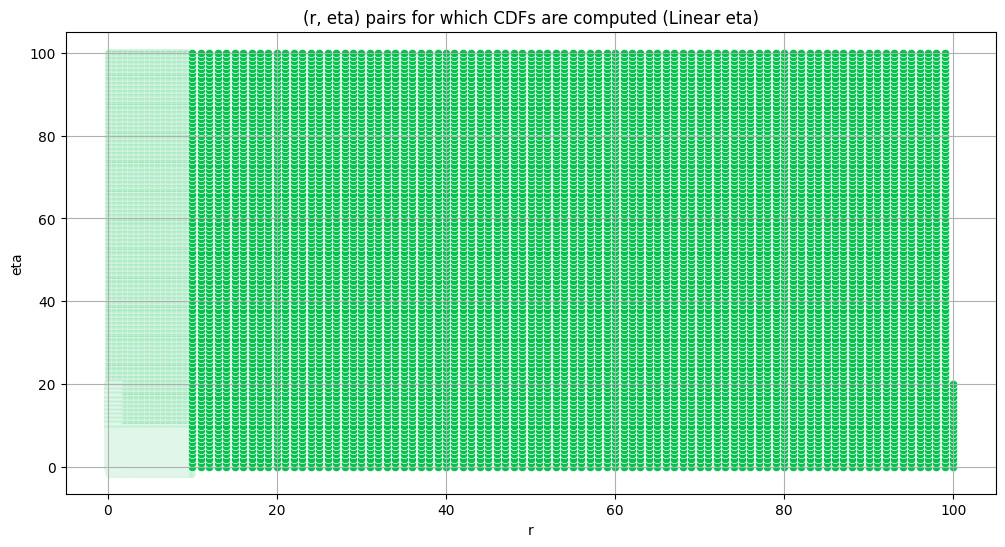

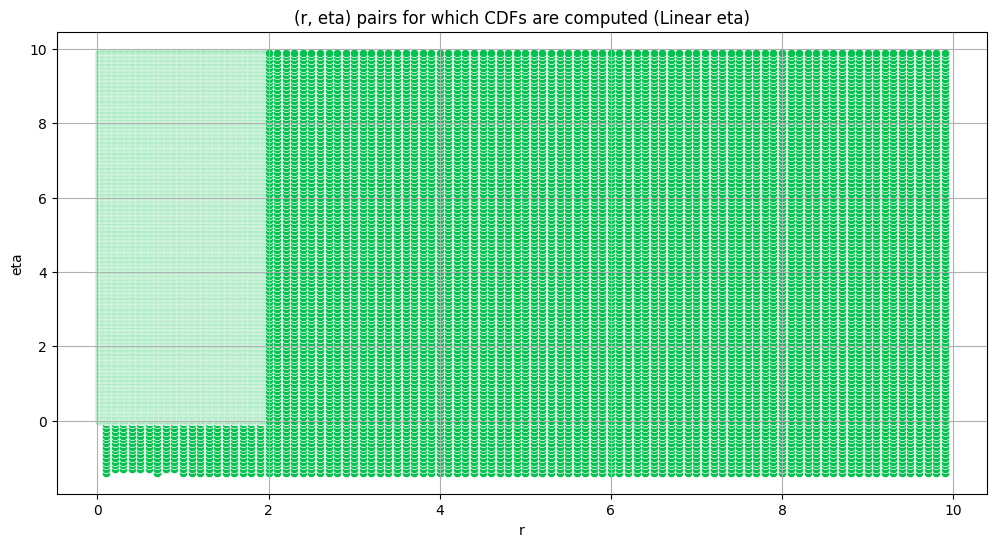

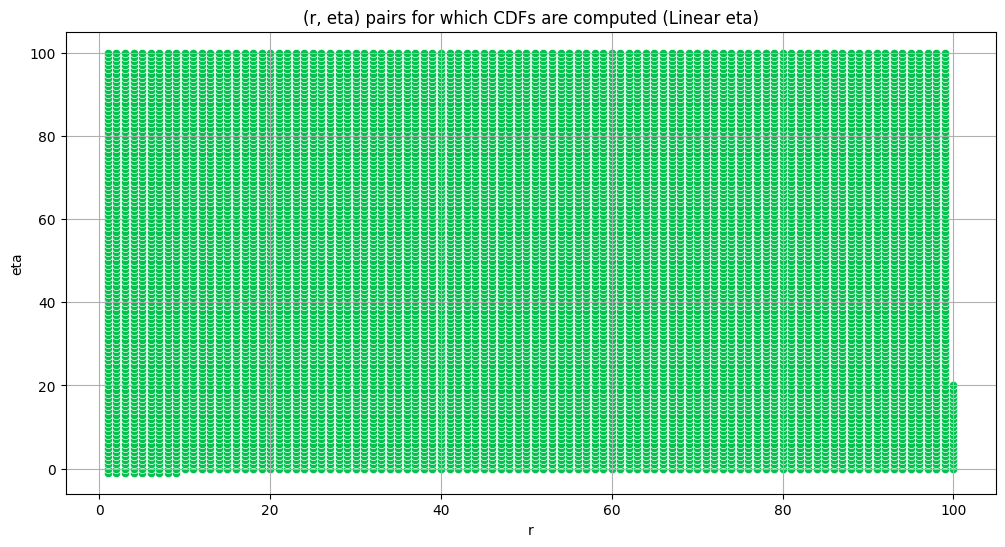

/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,49356.000000,49356.000000,4.935600e+04,4.812000e+04
mean,12.550652,22.614379,inf,inf
std,23.072257,28.488261,inf,NaN
min,0.020000,-1.400000,0.000000e+00,4.787254e-04
25%,1.040000,3.700000,9.924824e-01,1.305569e-02
50%,2.400000,8.000000,1.528212e+00,1.709859e-01
75%,8.400000,35.000000,5.855025e+00,5.394159e-01
max,100.000000,100.000000,1.797693e+308,inf


In [10]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [11]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99
eps_var = 50
eps_kurt = 5


 Layer 2


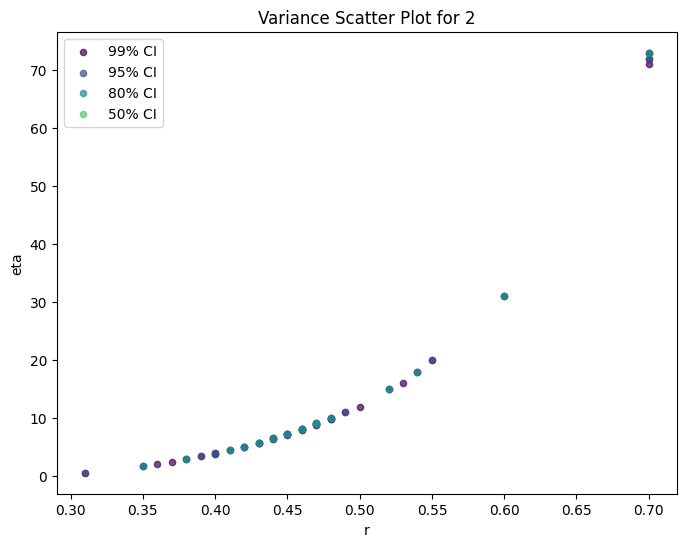

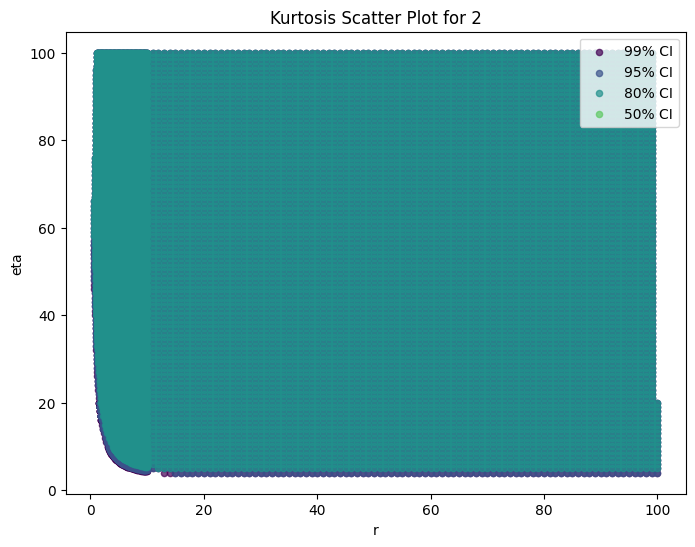


 Layer 3


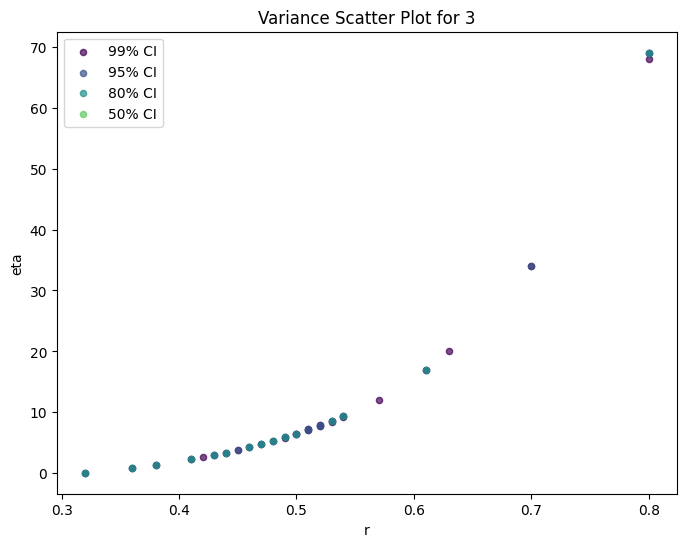

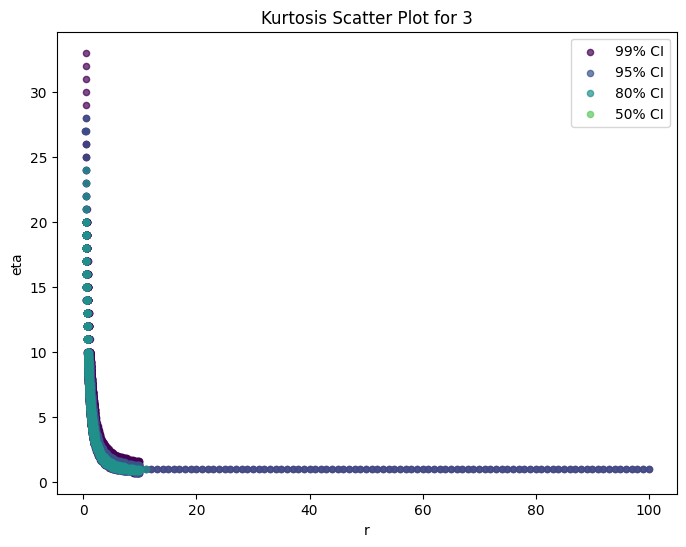


 Layer 4


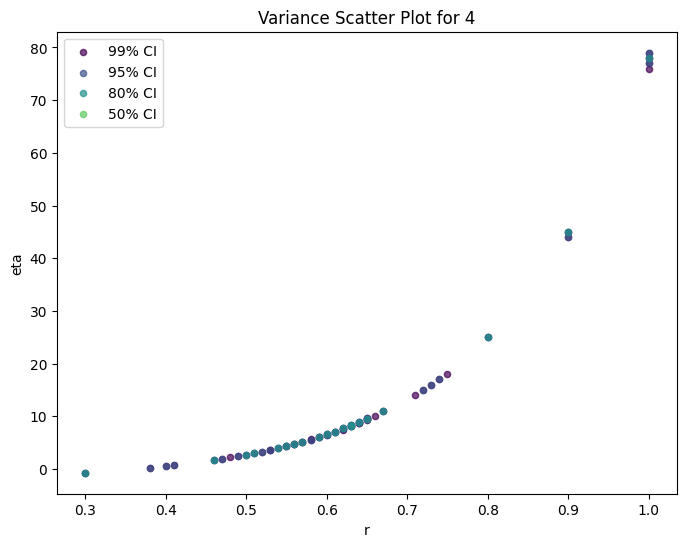

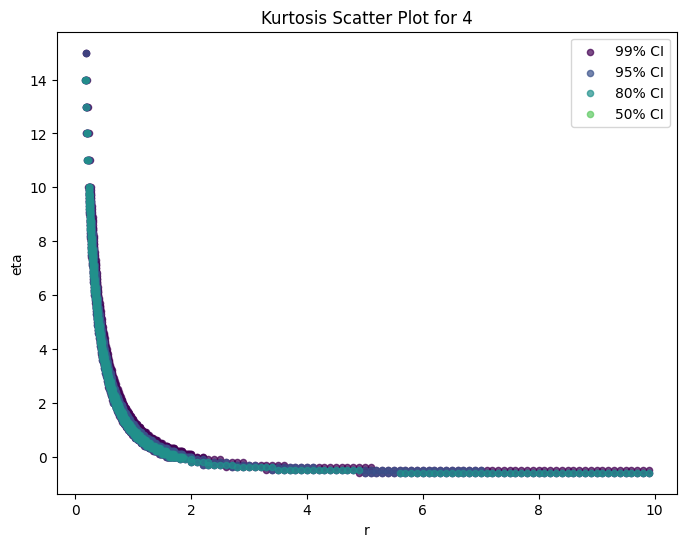


 Layer 5


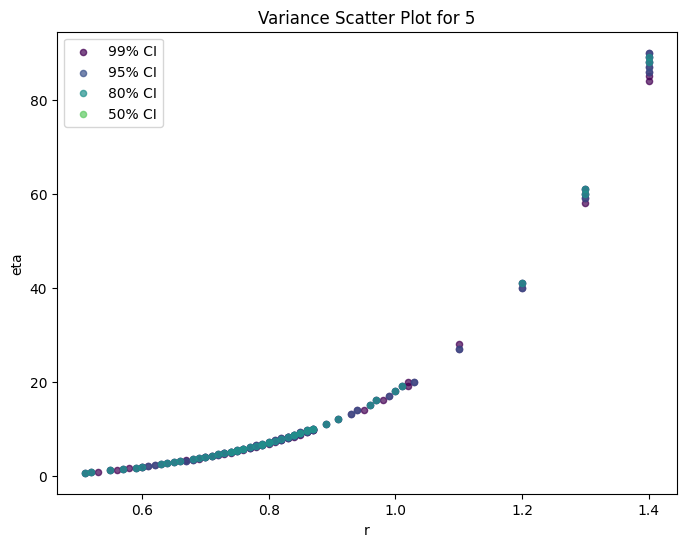

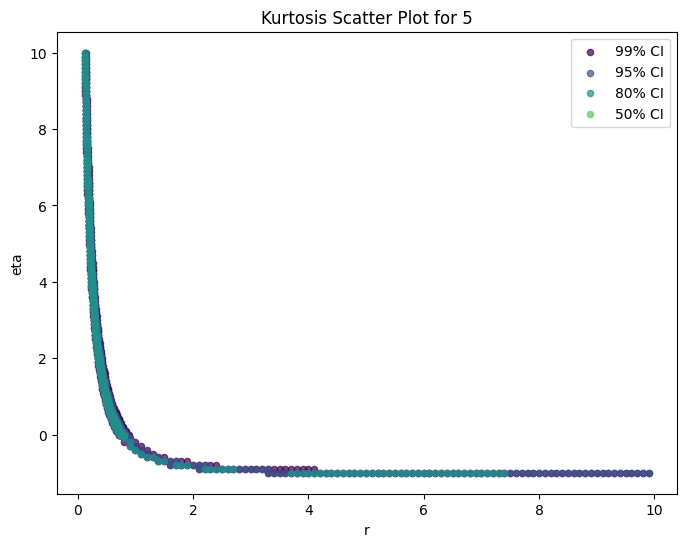


 Layer 6


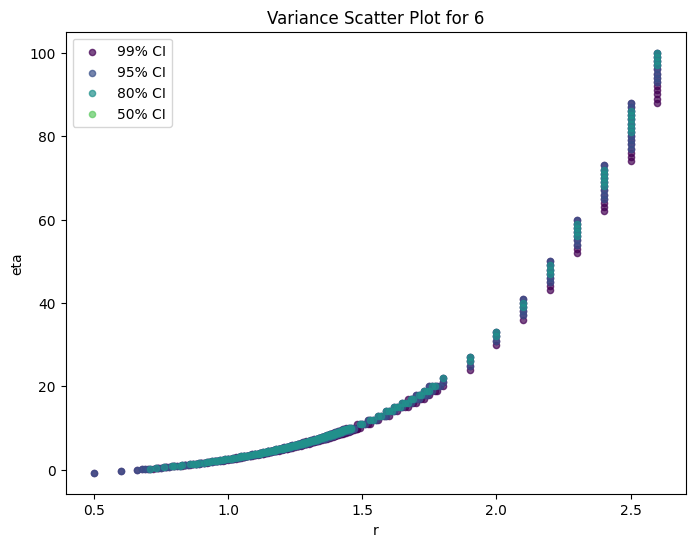

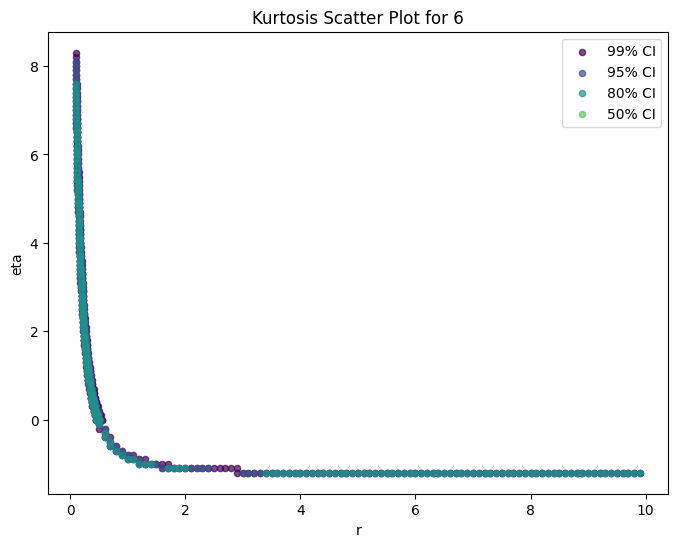


 Layer 7


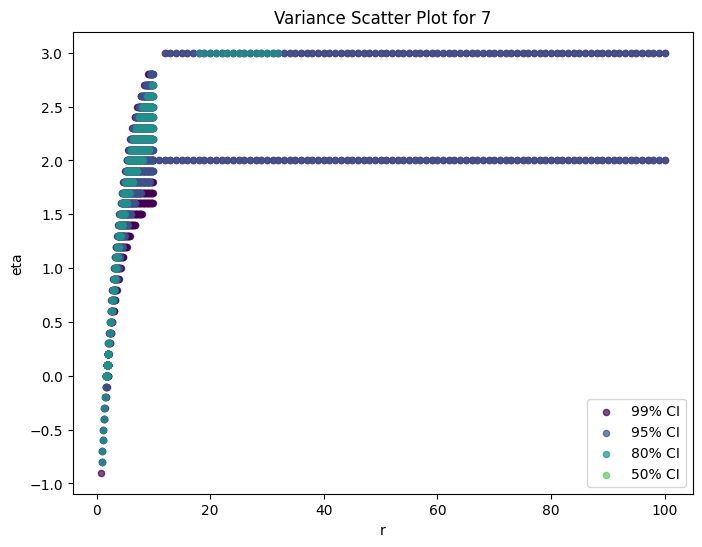

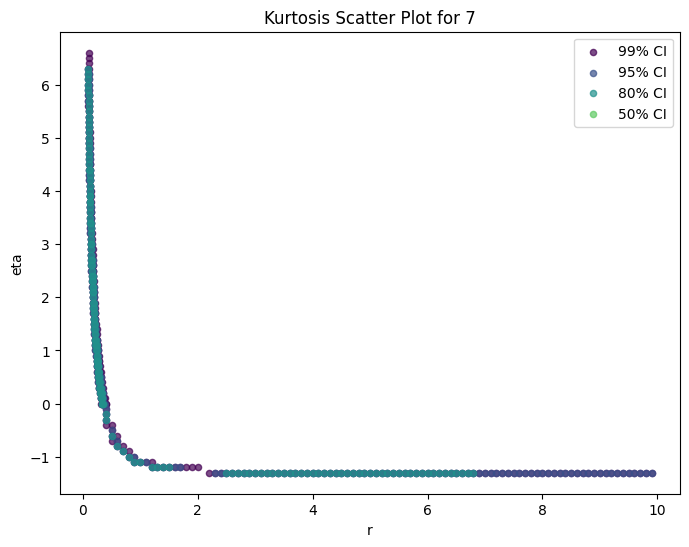


 Layer 8


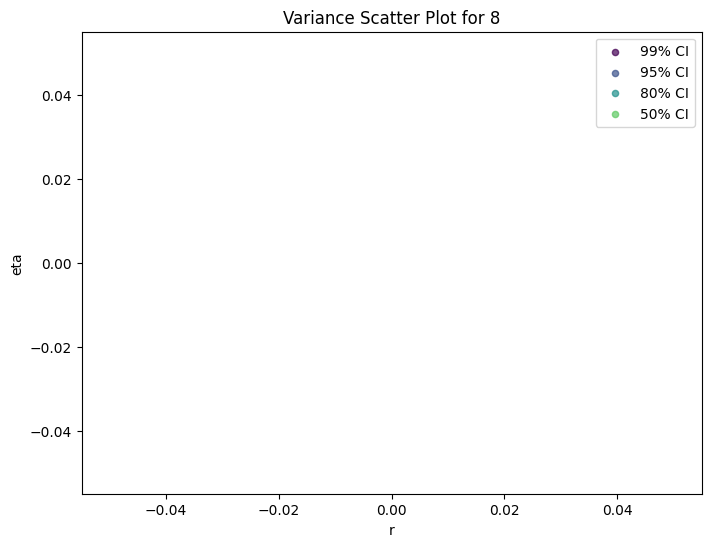

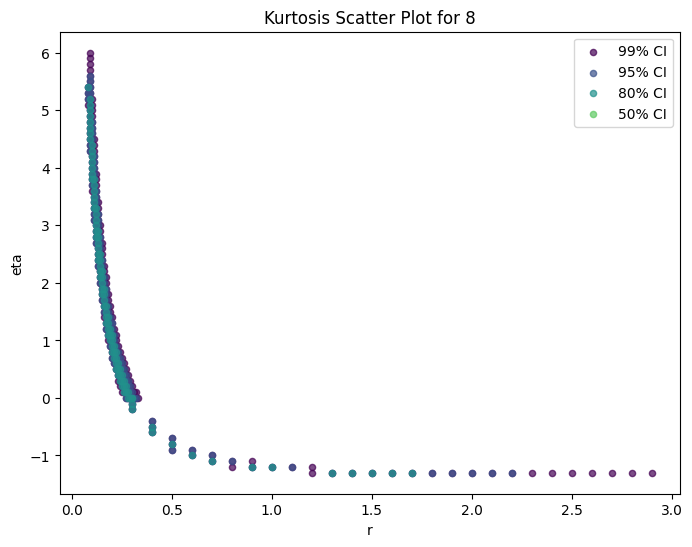

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper
layer,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474


In [12]:
''' Only need to run commented code once'''    
for group in  GROUPS:
    print(f'\n {GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= np.var, ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= stats.kurtosis, ci=ci)  
    group_cdf_df = all_cdfs_df.copy()
    group_cdf_df['pass_var'] = (group_cdf_df['variance'] > var_lower) & (group_cdf_df['variance'] < var_upper)
    group_cdf_df['pass_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower) & (group_cdf_df['kurtosis'] < kurt_upper)
    group_cdf_df['pass_eps_var'] = (group_cdf_df['variance'] > var_lower - eps_var) & (group_cdf_df['variance'] < var_upper + eps_var)
    group_cdf_df['pass_eps_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower - eps_kurt) & (group_cdf_df['kurtosis'] < kurt_upper + eps_kurt)

    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    group_cdf_df_dict[group] = group_cdf_df
    fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    plt.close(fig_var)
    fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    plt.close(fig_kurt)
pd.to_pickle(var_values_dict, os.path.join(CWD, "cache", f'var_values_dict_{n_bootstrap}_{bootstrap_size}.pickle'))
pd.to_pickle(kurt_values_dict, os.path.join(CWD, "cache", f'kurt_values_dict_{n_bootstrap}_{bootstrap_size}.pickle'))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_initial.pickle"))
master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_initial.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

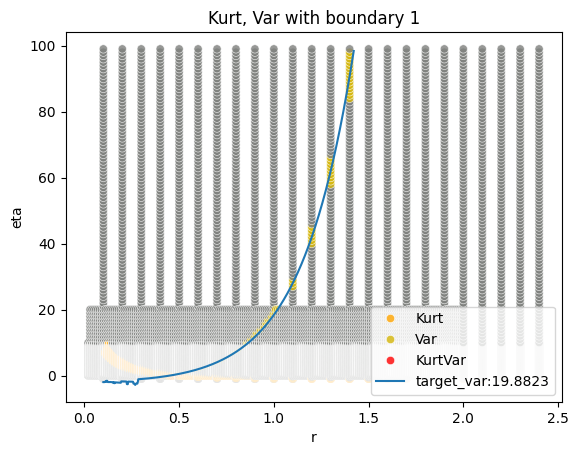

Lowest eta value: -2.0006894553021195


<Axes: title={'center': 'Kurt, Var with boundary 1'}, xlabel='r', ylabel='eta'>

In [13]:
# Example cell
group = 5
combo_test_plot(group_cdf_df_dict[group], ['pass_var','pass_kurt'], target_var = master_df.loc[group, 'obs_var'], extra_boundary=1)

####
Layer  2


100%|██████████| 49356/49356 [00:39<00:00, 1246.41it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 3180, Without approximation : 3180.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:812: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


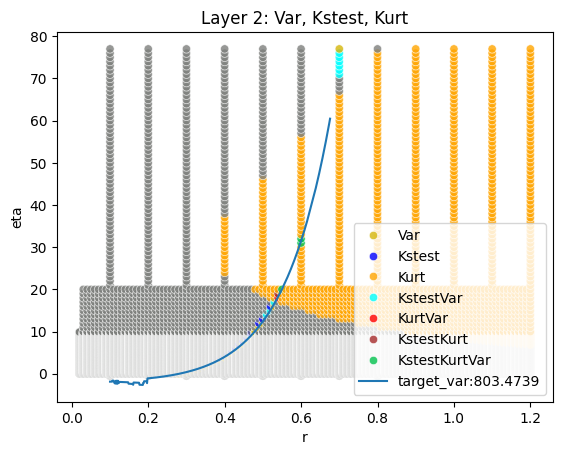

Lowest eta value: -1.8699283631751105
####
Layer  3


100%|██████████| 49356/49356 [00:22<00:00, 2199.80it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 12720, Without approximation : 12720.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:812: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


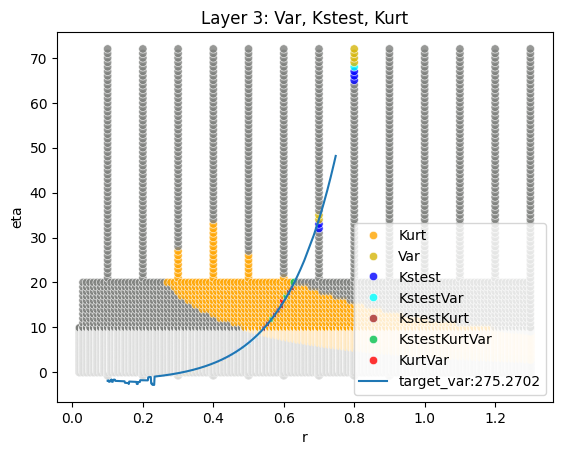

Lowest eta value: -1.8904985072030835
####
Layer  4


100%|██████████| 49356/49356 [01:14<00:00, 662.53it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 50880, Without approximation : 50880.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:812: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


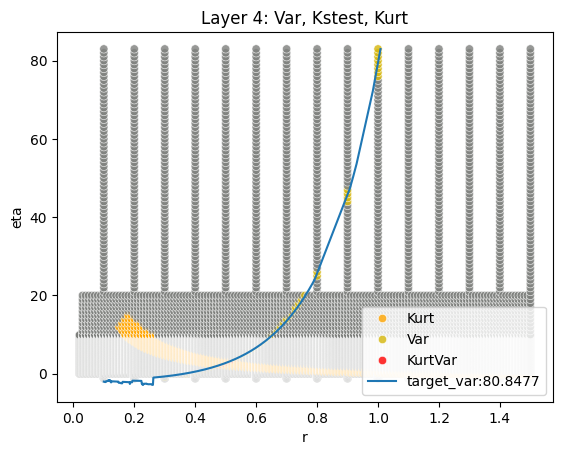

Lowest eta value: -2.0027947159845723
####
Layer  5


100%|██████████| 49356/49356 [02:28<00:00, 331.75it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 100000, Without approximation : 203520.0


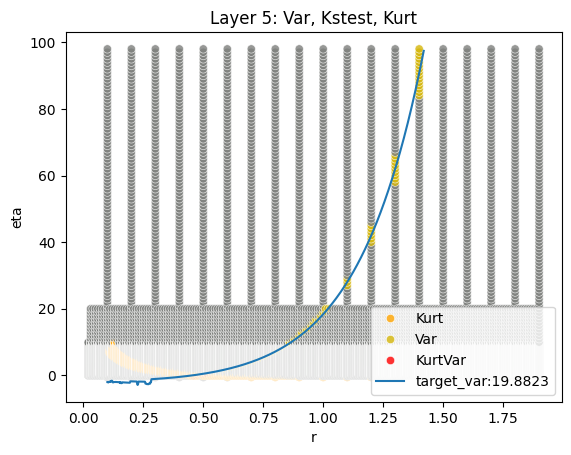

Lowest eta value: -2.0006894553021195
####
Layer  6


100%|██████████| 49356/49356 [02:27<00:00, 334.73it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 100000, Without approximation : 814080.0


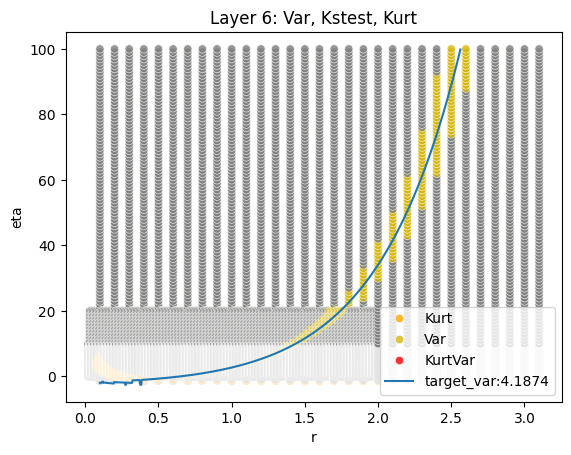

Lowest eta value: -2.0001453530785485
####
Layer  7


100%|██████████| 49356/49356 [02:39<00:00, 310.35it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 100000, Without approximation : 3256320.0


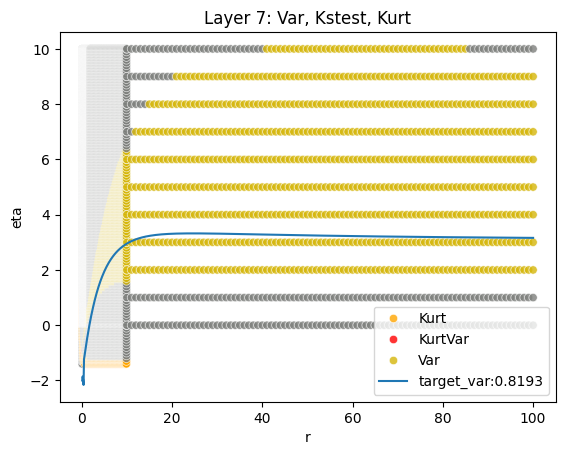

Lowest eta value: -2.0000284458959667
####
Layer  8


100%|██████████| 49356/49356 [02:29<00:00, 329.12it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 100000, Without approximation : 13025280.0


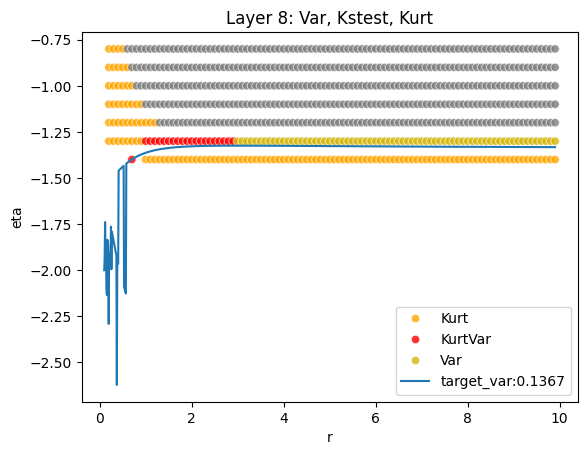

Lowest eta value: -2.0000047481104946


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,0.42,5.7,3180.0,0.018069,0.024030
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,0.51,7.3,12720.0,0.004615,0.012029
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,0.44,1.4,50880.0,0.006270,0.006018
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,0.47,0.2,203520.0,0.005236,0.003010
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,0.50,-0.6,814080.0,0.007522,0.001505
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,1.00,-0.9,3256320.0,0.011481,0.000753
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,0.70,-1.3,13025280.0,0.028140,0.000376


In [14]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'full-pastis-wavelet-gray-size.pickle'))

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = group_cdf_df_dict[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    master_df.loc[group, 'total_samples'] = group_total_samples[group]
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff
    group_cdf_df['ksstat'] = ksstats
    group_cdf_df['pass_kstest'] = group_cdf_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", target_var = master_df.loc[group, 'obs_var'])
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [15]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        group_cdfs = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, group_cdfs, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

100%|██████████| 369/369 [00:02<00:00, 161.99it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 2157.37it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 491.59it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 275.25it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 260.92it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 309.81it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 317.51it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,0.42,5.7,3180.0,0.018069,0.024030,0.060346,0.26
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,0.51,7.3,12720.0,0.004615,0.012029,0.037012,0.29
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,0.44,1.4,50880.0,0.006270,0.006018,0.023319,0.34
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,0.47,0.2,203520.0,0.005236,0.003010,0.005653,0.44
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,0.50,-0.6,814080.0,0.007522,0.001505,0.020507,0.74
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,1.00,-0.9,3256320.0,0.011481,0.000753,0.082284,6.10
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,0.70,-1.3,13025280.0,0.028140,0.000376,0.227351,6.00


In [16]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, use_matlab=True, eng=None, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)

    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            # if computed_cdf is None:
            #     with open("generate_CDF_log_yash.csv", 'a') as handle:
            #         handle.write(f"{r}, {eta}, {n_samples}, failed assert\n")
            #     continue
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}-{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [32]:
SKIP_OPTIMIZE_STEP = False

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
        eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
        simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "CDFs"), folder_name=f'{GROUP}{group}', n_samples = 200, debug=False)
        group_cdfs = combine_pickles(os.path.join(CWD, "CDFs", f'{GROUP}{group}'))
        ksstats, best_param, kstest_stat = gridsearch(sample, group_cdfs, debug=True)
        master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
        master_df.loc[group, 'kstest_stat_best'] = kstest_stat
        print(f"{GROUP} {group} best parameters: {best_param, master_df.loc[group, 'kstest_stat_best']}")

master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

Skipped 0.41 entirely
Skipped 0.411 entirely
Skipped 0.412 entirely
Skipped 0.413 entirely
Skipped 0.414 entirely
Skipped 0.415 entirely
Skipped 0.416 entirely
Skipped 0.417 entirely
Skipped 0.418 entirely
Skipped 0.419 entirely
Skipped 0.42 entirely
Skipped 0.421 entirely
Skipped 0.422 entirely
Skipped 0.423 entirely
Skipped 0.424 entirely
Skipped 0.425 entirely
Skipped 0.426 entirely
Skipped 0.427 entirely
Skipped 0.428 entirely
Skipped 0.429 entirely
Skipped 0.43 entirely


100%|██████████| 420/420 [00:00<00:00, 6776.38it/s]

Finding Minimum after computing 420 CDFs
layer 2 best parameters: ((0.42, 5.68), 0.017541839654943915)
Skipped 0.5 entirely
Skipped 0.501 entirely
Skipped 0.502 entirely
Skipped 0.503 entirely
Skipped 0.504 entirely
Skipped 0.505 entirely
Skipped 0.506 entirely
Skipped 0.507 entirely
Skipped 0.508 entirely
Skipped 0.509 entirely
Skipped 0.51 entirely
Skipped 0.511 entirely
Skipped 0.512 entirely
Skipped 0.513 entirely
Skipped 0.514 entirely
Skipped 0.515 entirely


(0.517, 7.29), 350 of 420
(0.519, 7.39), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 2309.09it/s]


Finding Minimum after computing 420 CDFs
layer 3 best parameters: ((0.509, 7.22), 0.004263272672758722)
(0.432, 1.37), 50 of 441
(0.434, 1.45), 100 of 441
(0.437, 1.32), 150 of 441
(0.439, 1.4), 200 of 441
(0.441, 1.48), 250 of 441
(0.444, 1.35), 300 of 441
(0.446, 1.43), 350 of 441
(0.449, 1.3), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 597.17it/s]


Finding Minimum after computing 441 CDFs
layer 4 best parameters: ((0.436, 1.31), 0.00531526560055795)
(0.462, 0.17), 50 of 441
(0.464, 0.25), 100 of 441
(0.467, 0.12), 150 of 441
(0.469, 0.2), 200 of 441
(0.471, 0.28), 250 of 441
(0.474, 0.15), 300 of 441
(0.476, 0.23), 350 of 441
(0.479, 0.1), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 328.65it/s]


Finding Minimum after computing 441 CDFs
layer 5 best parameters: ((0.462, 0.13), 0.003906056663921298)
(0.42, -0.61), 50 of 400
(0.44, -0.51), 100 of 400
(0.47, -0.61), 150 of 400
(0.49, -0.51), 200 of 400
(0.52, -0.61), 250 of 400
(0.54, -0.51), 300 of 400
(0.57, -0.61), 350 of 400
(0.59, -0.51), 400 of 400


100%|██████████| 400/400 [00:01<00:00, 339.42it/s]


Finding Minimum after computing 400 CDFs
layer 6 best parameters: ((0.52, -0.58), 0.003109999999999058)
(0.92, -0.91), 50 of 420
(0.94, -0.81), 100 of 420
(0.97, -0.91), 150 of 420
(0.99, -0.81), 200 of 420
(1.02, -0.91), 250 of 420
(1.04, -0.81), 300 of 420
(1.07, -0.91), 350 of 420
(1.09, -0.81), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 279.99it/s]


Finding Minimum after computing 420 CDFs
layer 7 best parameters: ((0.91, -0.92), 0.008432433497601588)
(0.62, -1.33), 50 of 420
(0.64, -1.25), 100 of 420
(0.67, -1.38), 150 of 420
(0.69, -1.3), 200 of 420
(0.71, -1.22), 250 of 420
(0.74, -1.35), 300 of 420
(0.76, -1.27), 350 of 420
(0.79, -1.4), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 310.39it/s]


Finding Minimum after computing 420 CDFs
layer 8 best parameters: ((0.7, -1.26), 0.03554324514215251)


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,n_pval_0.05
layer,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,0.42,5.7,3180.0,0.018069,0.024030,0.060346,0.26,0.420,5.68,0.017542,6034
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,0.51,7.3,12720.0,0.004615,0.012029,0.037012,0.29,0.509,7.22,0.004263,96592
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,0.44,1.4,50880.0,0.006270,0.006018,0.023319,0.34,0.436,1.31,0.005315,64395
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,0.47,0.2,203520.0,0.005236,0.003010,0.005653,0.44,0.462,0.13,0.003906,122248
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,0.50,-0.6,814080.0,0.007522,0.001505,0.020507,0.74,0.520,-0.58,0.003110,193185
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,1.00,-0.9,3256320.0,0.011481,0.000753,0.082284,6.10,0.910,-0.92,0.008432,25440
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,0.70,-1.3,13025280.0,0.028140,0.000376,0.227351,6.00,0.700,-1.26,0.035543,1507


## Comparing Empirical and Computed CDF/PDF

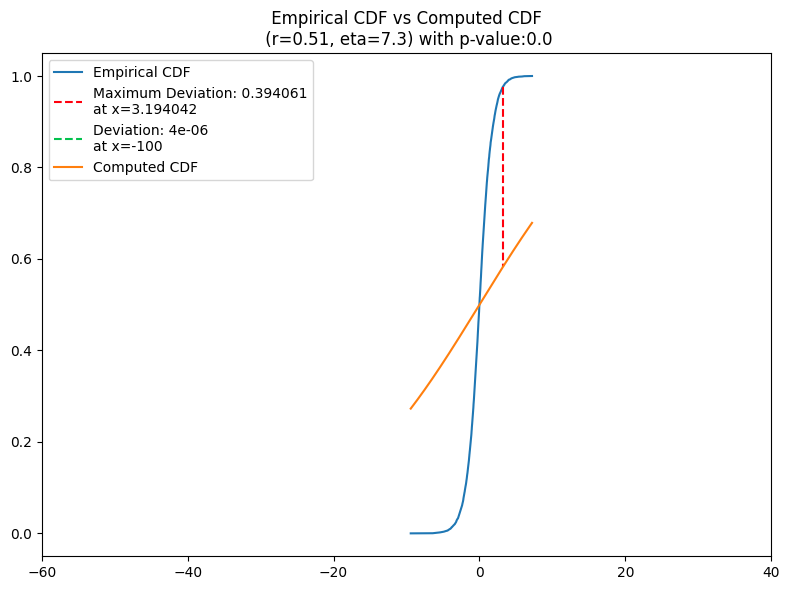

In [33]:
# Example Cell
group = 3
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

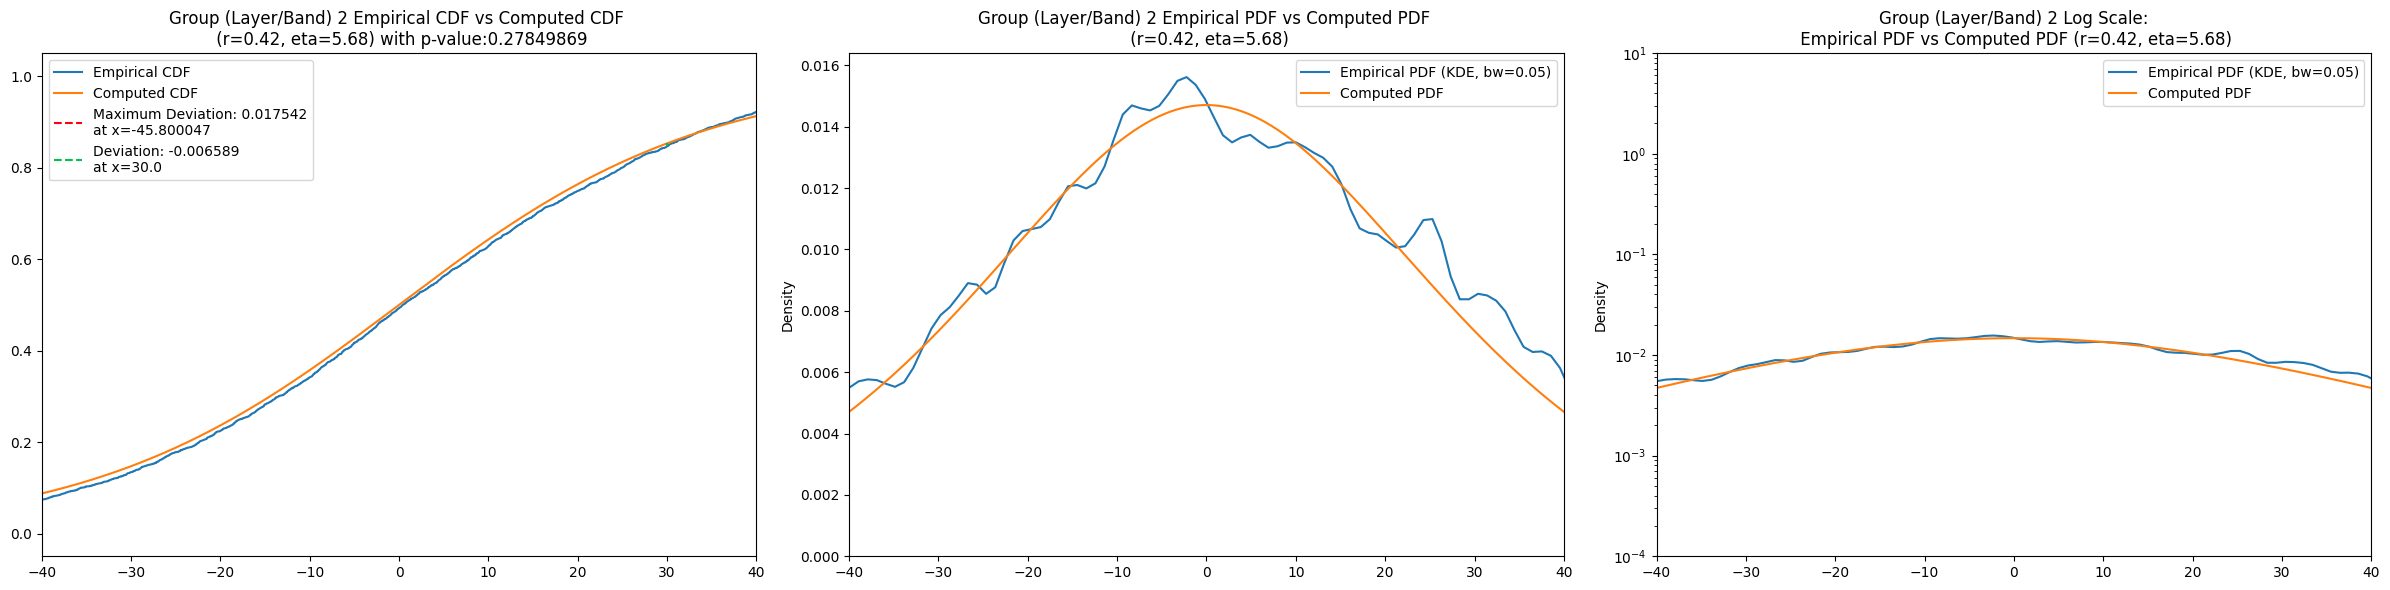

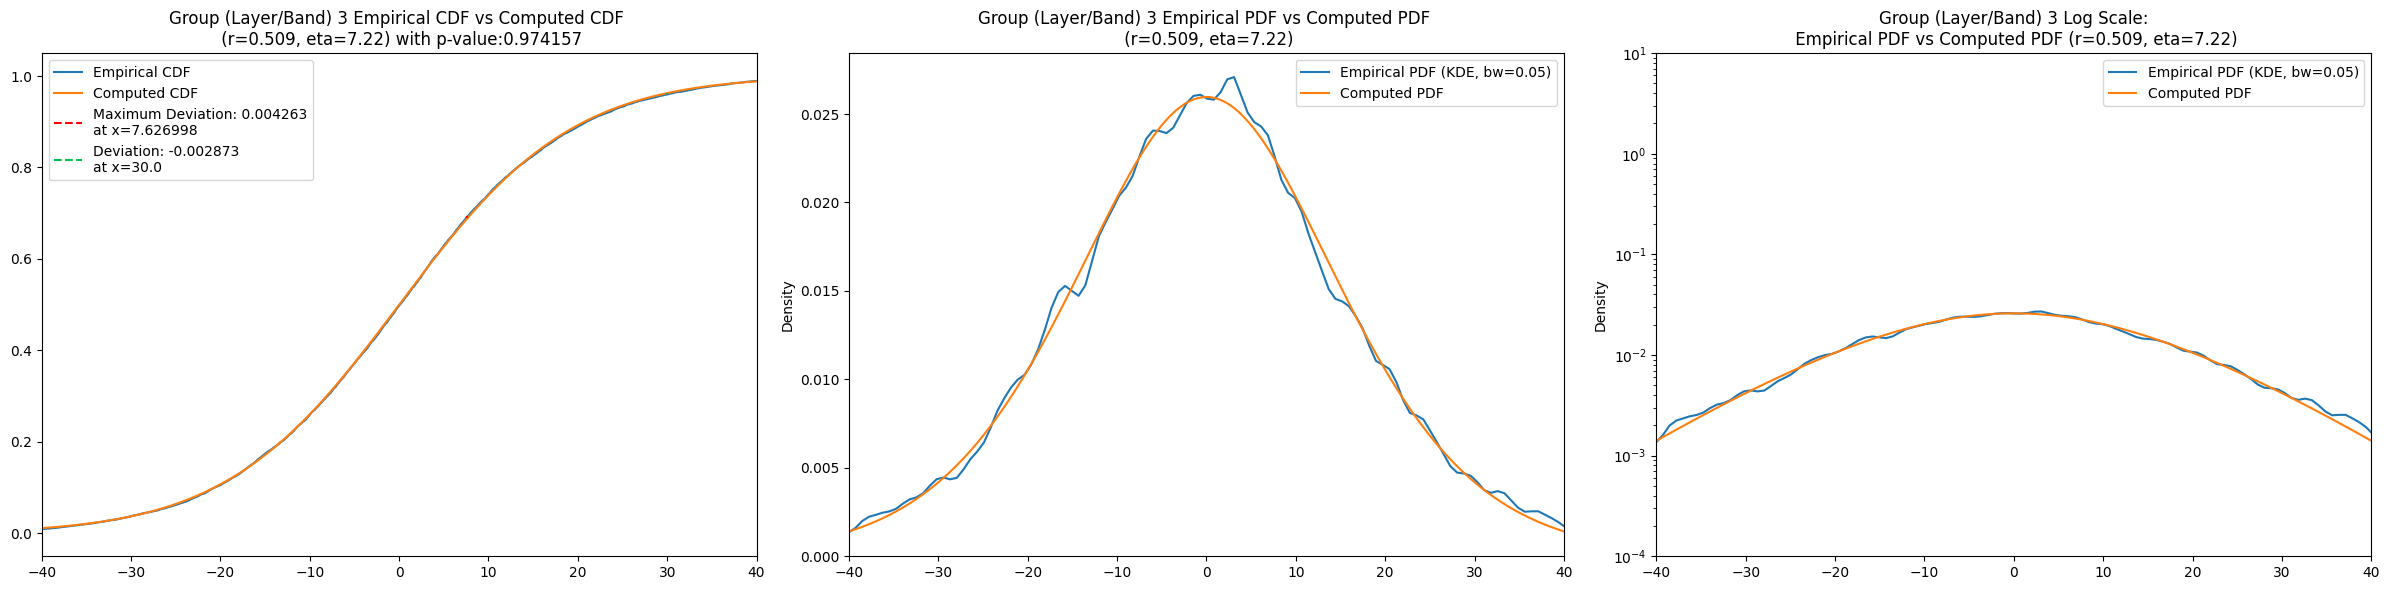

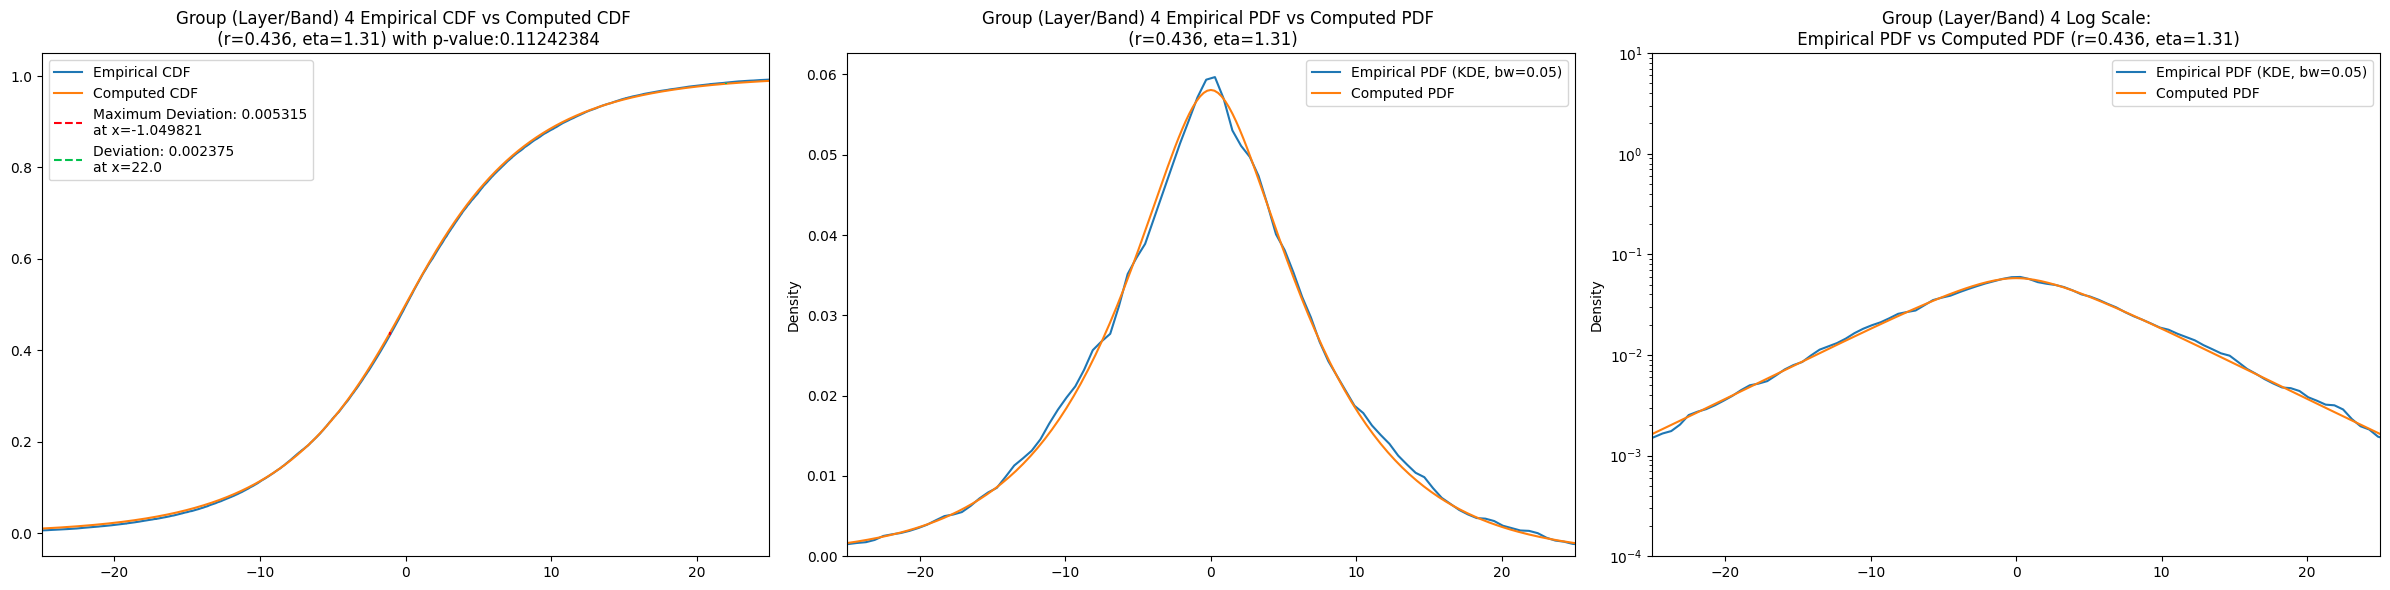

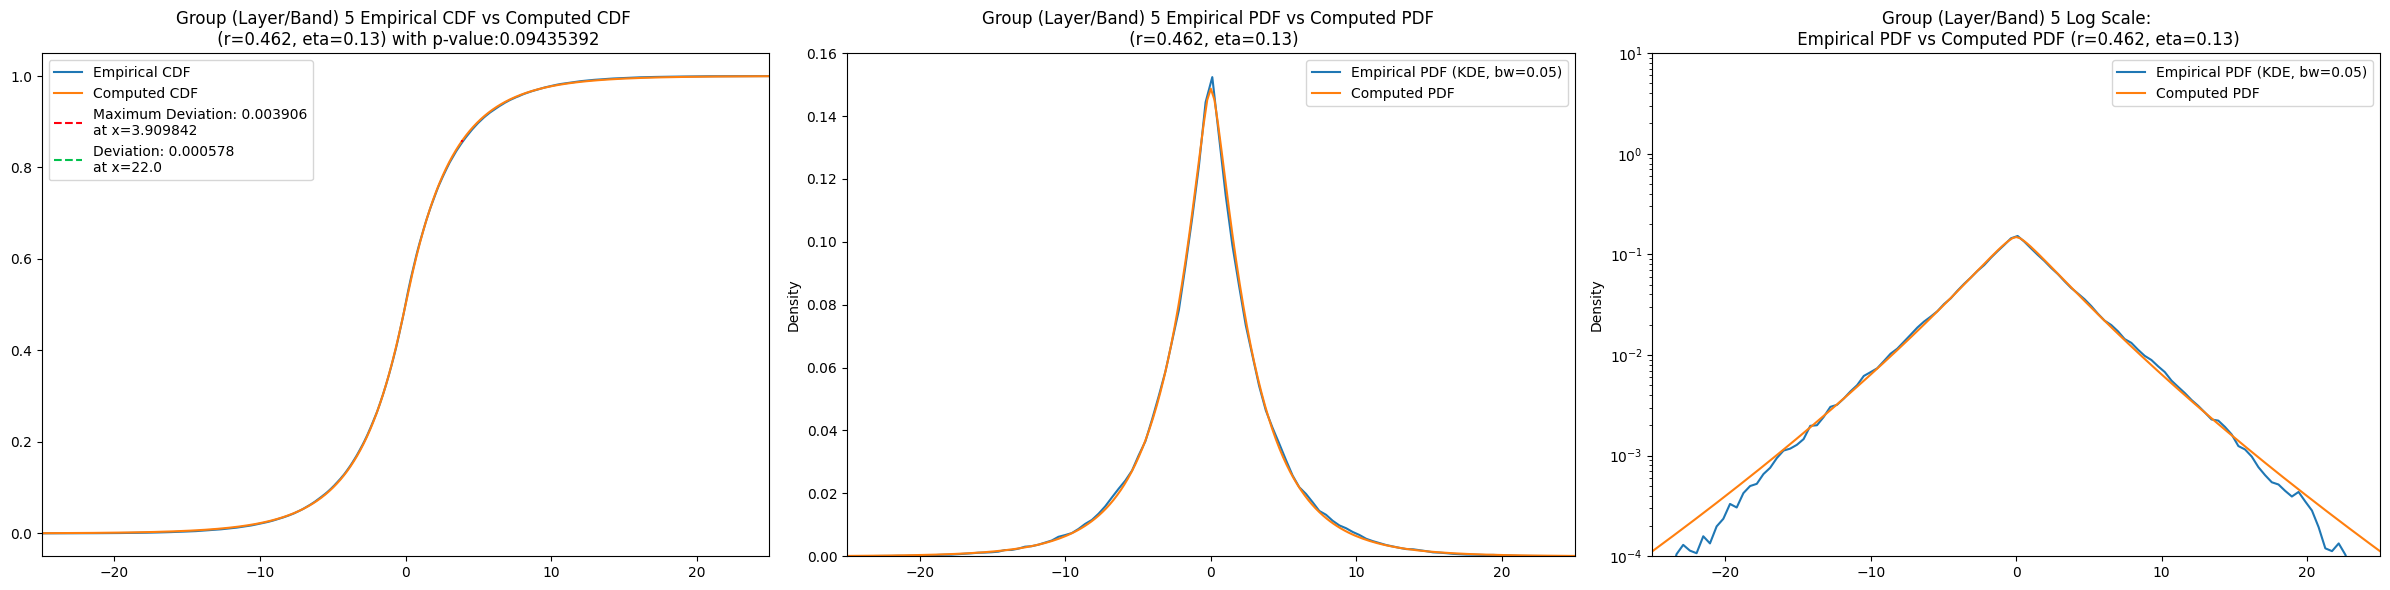

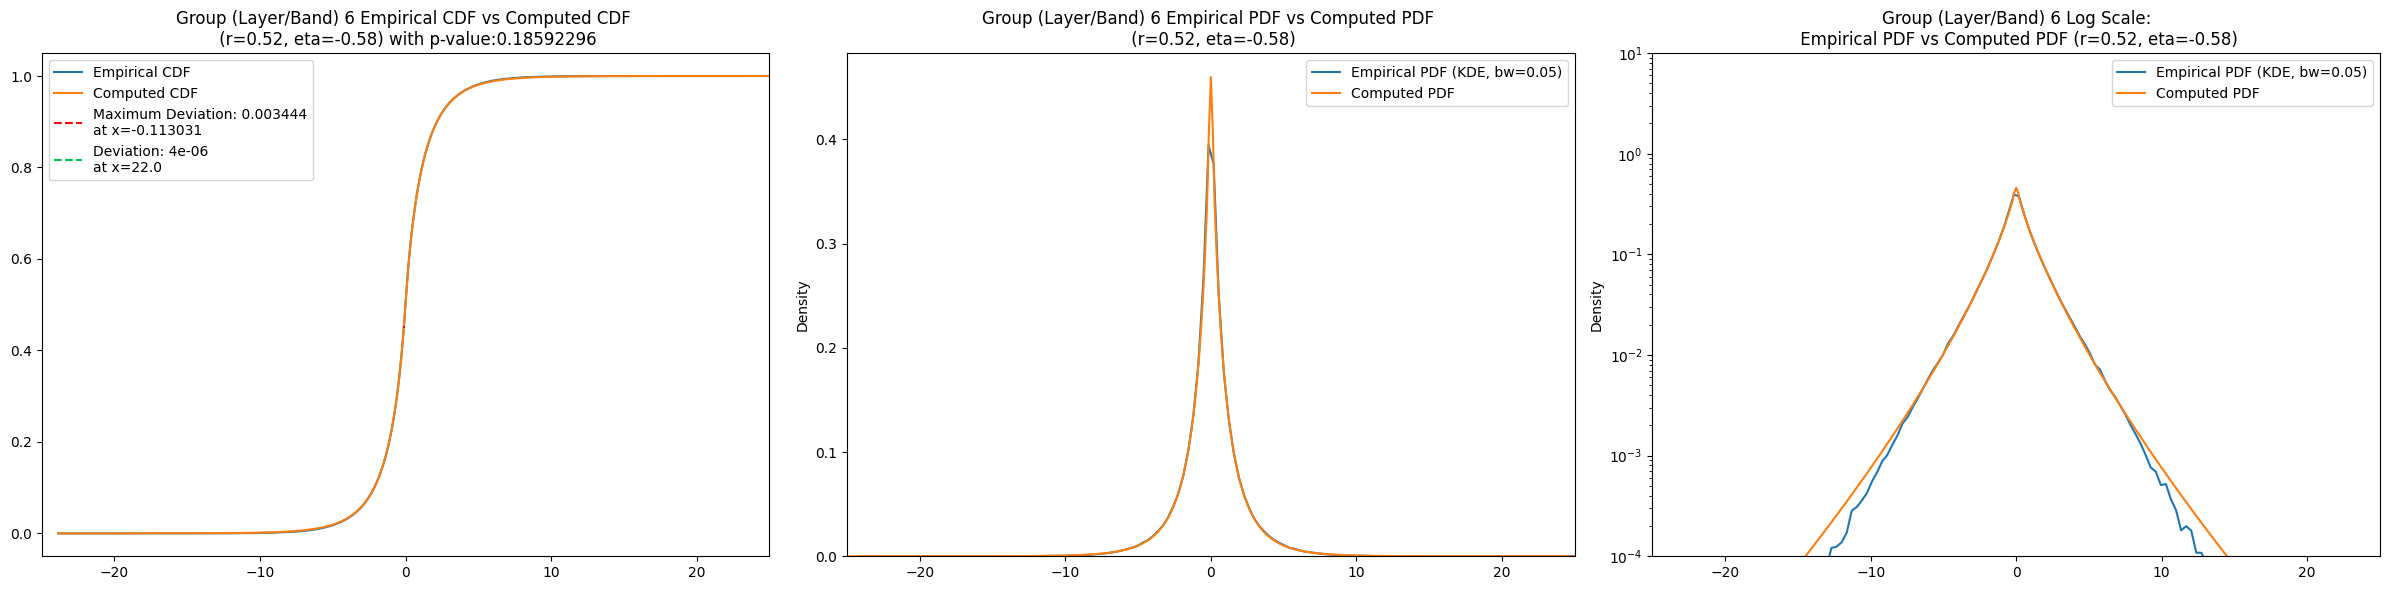

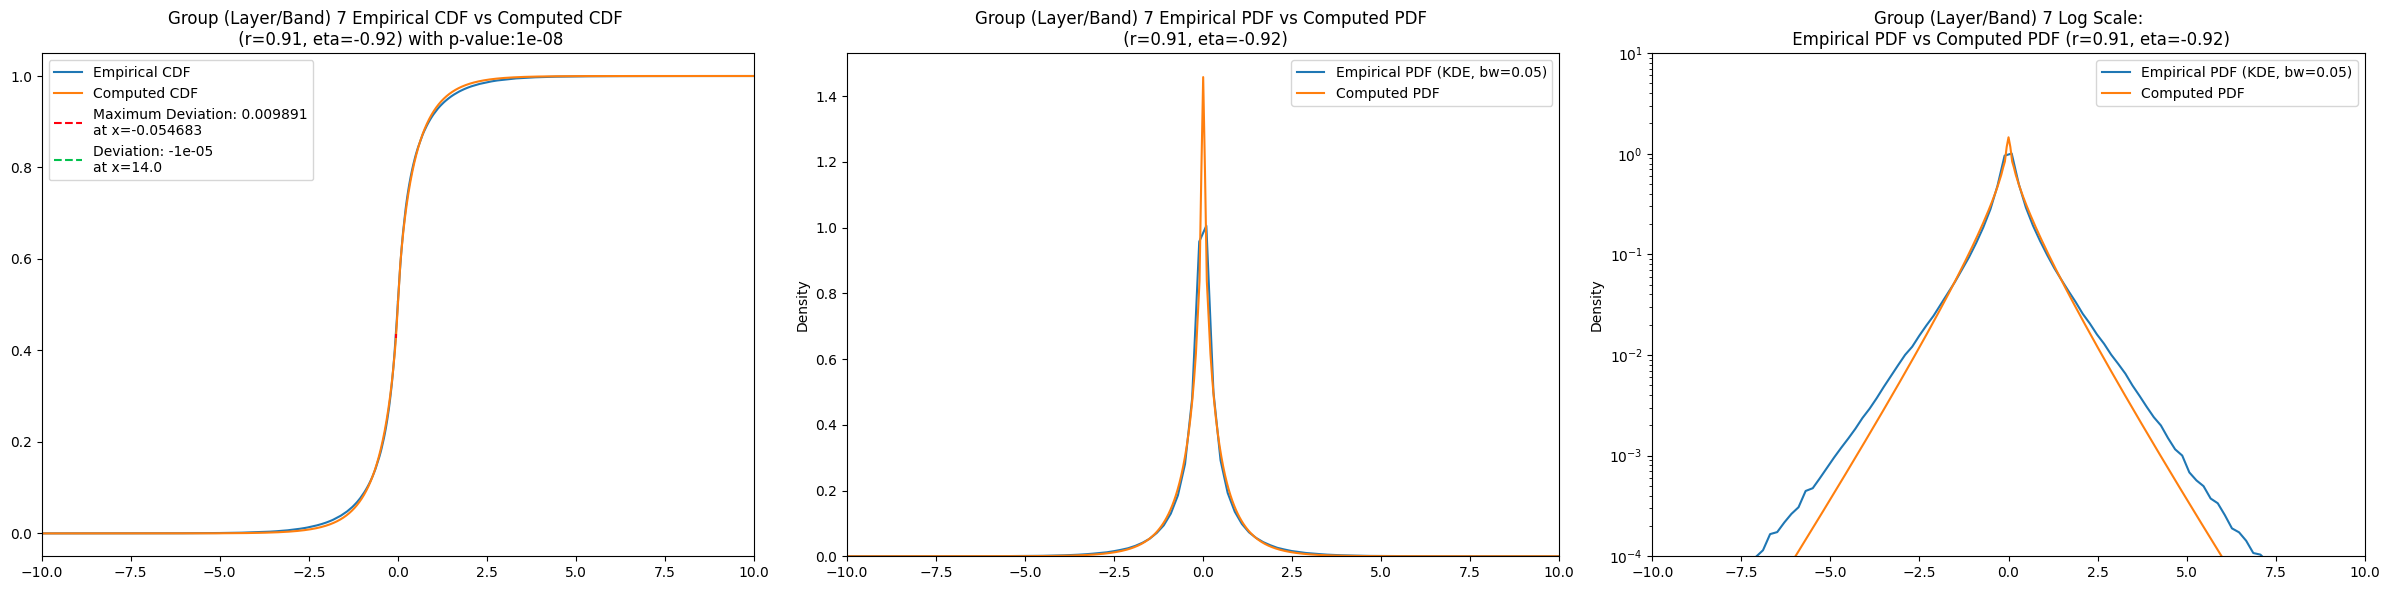

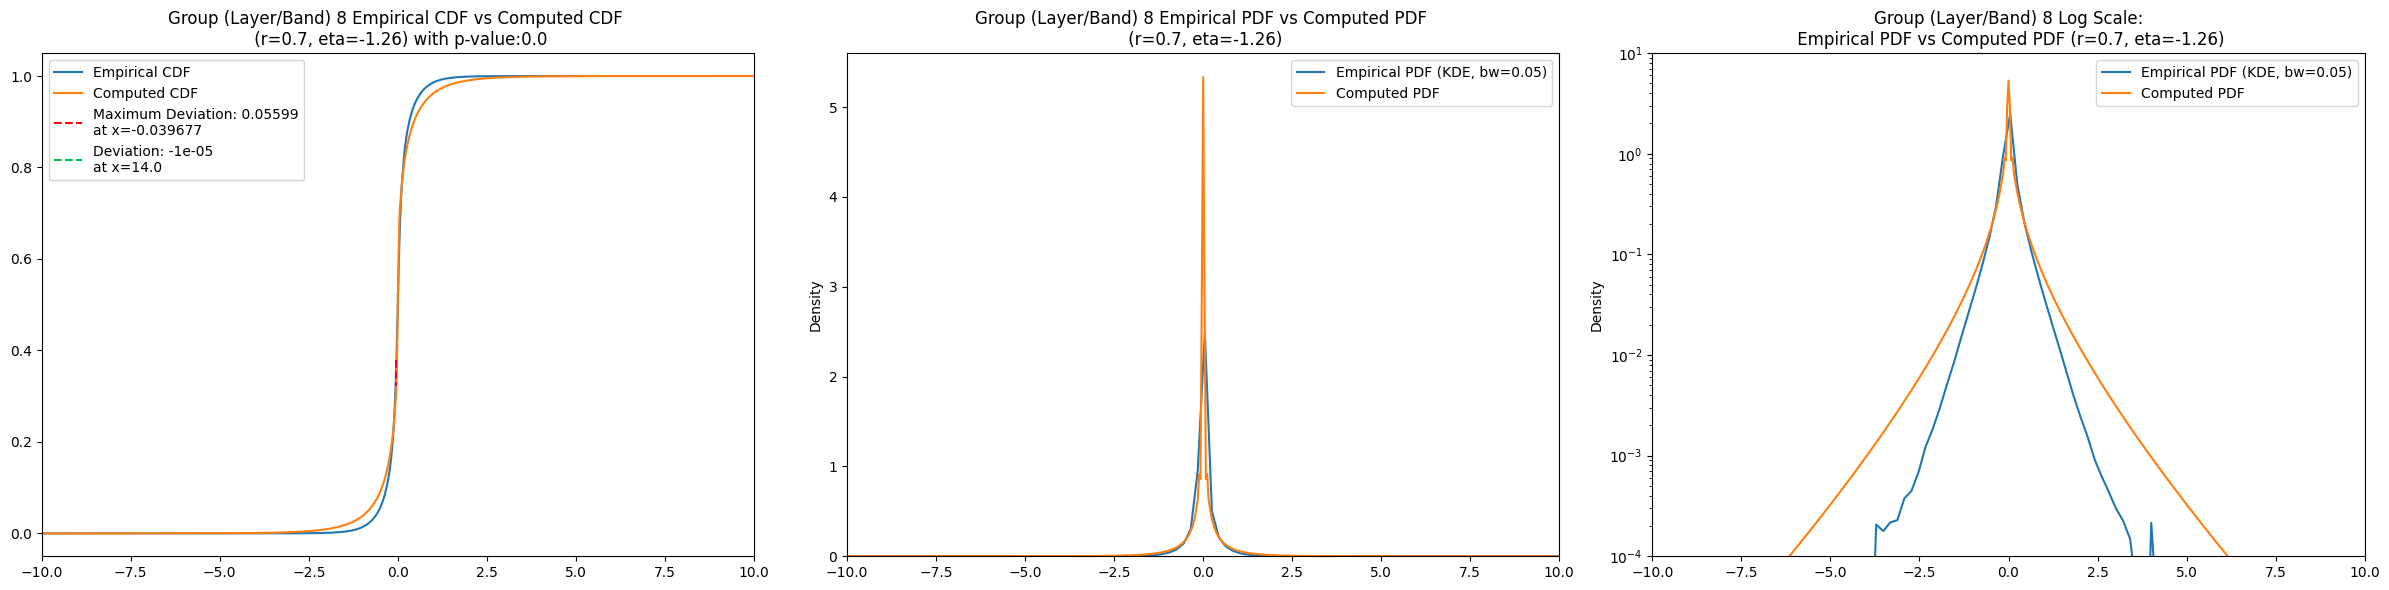

In [34]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [36]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [37]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,0.42,5.7,3180.0,0.018069,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,2.785000e-01
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,0.51,7.3,12720.0,0.004615,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,9.741600e-01
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,0.44,1.4,50880.0,0.006270,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,1.124200e-01
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,0.47,0.2,203520.0,0.005236,...,3.590200,0.030178,1.856120e-161,3.138870,0.002344,2.129390e-01,2.574090,0.010570,3.529230e-20,4.006700e-03
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,0.50,-0.6,814080.0,0.007522,...,1.426190,0.042375,0.000000e+00,1.246800,0.014481,1.041130e-148,1.010540,0.017941,4.909420e-228,2.890500e-07
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,1.00,-0.9,3256320.0,0.011481,...,0.539656,0.052929,0.000000e+00,0.472760,0.025282,0.000000e+00,0.378321,0.026440,0.000000e+00,1.521600e-201
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,0.70,-1.3,13025280.0,0.028140,...,0.196027,0.056358,0.000000e+00,0.172569,0.029152,0.000000e+00,0.137349,0.028140,0.000000e+00,0.000000e+00


# Examining Tail Behavior

In [ ]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_7.jpg'), bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_8.jpg'), bbox_inches = 'tight')

In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
            elif distro == 'gaussian':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in GROUPS:
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

# Results

## KS-Test Statistics

In [38]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,,,
2,3180.0,0.018069,0.024030,0.060346,0.017542,0.019503,0.036392,0.036305
3,12720.0,0.004615,0.012029,0.037012,0.004263,0.010128,0.022665,0.026410
4,50880.0,0.006270,0.006018,0.023319,0.005315,0.020474,0.014498,0.018489
5,203520.0,0.005236,0.003010,0.005653,0.003906,0.030178,0.002344,0.010570
6,814080.0,0.007522,0.001505,0.020507,0.003110,0.042375,0.014481,0.017941
7,3256320.0,0.011481,0.000753,0.082284,0.008432,0.052929,0.025282,0.026440
8,13025280.0,0.028140,0.000376,0.227351,0.035543,0.056358,0.029152,0.028140
